<a href="https://colab.research.google.com/github/JinwangMok/UNI_BigData/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 학기말 프로젝트

## 🎯 목표
> ```
> 서울에 사는 평범한 50대 직장인 나창업씨는 코로나가 끝나감에 따라 다니던 회사를 그만두고 오랜 꿈이었던 요식업에 뛰어들고자 한다.
> 그는 양식음식점을 개점하고자 하며 20대와 30대 연령층의 유동량이 많은 상권을 요구한다.
> 이에 20대와 30대 연령층의 유동량이 많은 2개의 상권에 대해 비교 및 분석하고 보고자하고자 한다.
> ```
> 
> 💽 사용 데이터
>>- [서울시 우리마을가게 상권분석서비스(상권-추정매출)](https://data.seoul.go.kr/dataList/OA-15572/S/1/datasetView.do)
>>
>>- [서울시 우리마을가게 상권분석서비스(상권-생활인구)](https://data.seoul.go.kr/dataList/OA-15568/S/1/datasetView.do)
>>
>>- [서울시 우리마을가게 상권분석서비스(상권-점포)](http://data.seoul.go.kr/dataList/OA-15577/S/1/datasetView.do)


## 0. 💼 시작하기 전에...

먼저 필요한 라이브러리와 모듈을 불러오고, 구글 드라이브를 마운트하는 등 데이터 분석 및 시각화에 필요한 작업을 진행해줍니다.

### 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pathlib
from tqdm import tqdm
import math

### 한글 폰트 설치 및 적용

> 아래의 셀을 실행하여 폰트 설치 후 런타임 다시 시작

In [2]:
# Install font for korean lang
# You must Restart Kernel after run this cell
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [3]:
# Set default style for plt and set font
plt.style.use('seaborn-white')

plt.rc('font', family='NanumBarunGothic')

### Google drive 마운트

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 고정 변수 선언

In [5]:
PATH = "/content/gdrive/MyDrive/BU/3-2/빅데이터/project/"
SERVICE_KEY = "6c56535547776c7336316c6c6f7142"

### 데이터 불러오기

> `sales_df` : 서울시 상권 매출 데이터 원본
>
> `population_df` : 서울시 상권 생활인구 데이터 원본

In [6]:
_path = list(pathlib.Path(PATH+'상권매출').rglob('*.csv'))
sales_df = pd.read_csv(_path[0], encoding='cp949')

for p in tqdm(_path[1:], desc="csv파일을 읽어오는 중입니다..."):
    sales_df = pd.concat([sales_df, pd.read_csv(p, encoding='cp949')])

sales_df = sales_df.sort_values(by=['기준_년_코드', '기준_분기_코드', '상권_코드'])
sales_df = sales_df.reset_index(drop=True)

csv파일을 읽어오는 중입니다...: 100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


In [7]:
sales_df.head(2)

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2017,1,U,관광특구,1001491,이태원 관광특구,CS100001,한식음식점,10929390463,331140,...,77882,168440,129834,2321,142199,92141,32126,20590,8914,108
1,2017,1,U,관광특구,1001491,이태원 관광특구,CS100002,중식음식점,2524192944,97748,...,9794,44246,45338,873,37987,27577,12469,7735,2952,17


In [8]:
population_df = pd.read_csv(PATH+'서울시 우리마을가게 상권분석서비스(상권-생활인구).csv', encoding='cp949')

In [9]:
population_df.head(2)

,기준 년코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,...,여성연령대_60_이상_토요일시간대_3_생활인구_수,여성연령대_60_이상_토요일시간대_4_생활인구_수,여성연령대_60_이상_토요일시간대_5_생활인구_수,여성연령대_60_이상_토요일시간대_6_생활인구_수,여성연령대_60_이상_일요일시간대_1_생활인구_수,여성연령대_60_이상_일요일시간대_2_생활인구_수,여성연령대_60_이상_일요일시간대_3_생활인구_수,여성연령대_60_이상_일요일시간대_4_생활인구_수,여성연령대_60_이상_일요일시간대_5_생활인구_수,여성연령대_60_이상_일요일시간대_6_생활인구_수
0,2021,4,U,관광특구,1001496,강남 마이스 관광특구,102294,51045,51249,6685,...,165,162,146,44,65,106,136,143,122,42
1,2021,4,U,관광특구,1001495,잠실 관광특구,3371333,1642782,1728551,336818,...,6171,6438,7573,4084,6809,6814,5921,6162,7116,4012


---

## 1. 20대, 30대 유동인구가 많은 상권은 어디일까?

> 유동인구를 구하기 위해 `서울시 우리마을가게 상권분석서비스(상권-생활인구).csv` 데이터를 활용해 20대, 30대 생활인구가 가장 많은 상권을 5군데 선정합니다.
>
> 본 데이터의 `생활인구`는 서울시와 KT가 공공빅데이터와 통신데이터를 이용하여 작성한 서울의 특정지역, 특정시점에 존재하는 인구수를 의미합니다.

In [10]:
columns_2030 = ['기준 년코드', '기준_분기_코드', '상권_코드_명', '총_생활인구_수', '연령대_20_생활인구_수', '연령대_30_생활인구_수']
population_df_2030 = population_df[columns_2030]

In [11]:
population_df_2030.head(3)

,기준 년코드,기준_분기_코드,상권_코드_명,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수
0,2021,4,강남 마이스 관광특구,102294,21900,28948
1,2021,4,잠실 관광특구,3371333,754106,804522
2,2021,4,종로?청계 관광특구,3868466,651068,723927


> 본 데이터의 하나의 행(row, record)은 `특정 년도`의 `특정 분기`의 `특정 상권`의 데이터를 의미합니다.
>
> 따라서 아래와 같이 동일한 상권 코드명으로 검색하면 해당 상권의 기간 내의 생활 인구 수가 검색됩니다.

In [12]:
population_df_2030[population_df_2030['상권_코드_명']=='잠실 관광특구']

,기준 년코드,기준_분기_코드,상권_코드_명,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수
1,2021,4,잠실 관광특구,3371333,754106,804522
1669,2021,3,잠실 관광특구,3029714,669658,728719
3337,2021,2,잠실 관광특구,2998695,680201,724138
5005,2021,1,잠실 관광특구,2941031,648879,706733
6673,2020,4,잠실 관광특구,2956754,662136,712862
8341,2020,3,잠실 관광특구,2998786,688346,710127
10010,2020,2,잠실 관광특구,3026454,681334,701941
11678,2020,1,잠실 관광특구,3066519,681379,687277
13347,2019,4,잠실 관광특구,3225556,697329,715276
15016,2019,3,잠실 관광특구,3180318,697516,698153


> 따라서, `어떤 상권이 2030 연령대의 생활인구가 가장 많은가?`를 확인하기 위해서 두가지 관점에서 확인해보고자 합니다.
>
>> 1) 가장 최근 데이터인 2021년도 4분기에 가장 많은 2030 생활 인구 수를 기록한 상권 5곳은 어디인가?
>>
>> 2) 평균적으로 가장 많은 2030 생활 인구 수를 기록한 상권 5곳은 어디인가?

### 1) 가장 최근 데이터인 2021년도 4분기에 가장 많은 2030 생활 인구 수를 기록한 상권 5곳은 어디인가?

In [13]:
population_df_2030[(population_df_2030['기준 년코드']==2021)&(population_df_2030['기준_분기_코드']==4)].sort_values(by='연령대_20_생활인구_수', ascending=False)[:5]

,기준 년코드,기준_분기_코드,상권_코드_명,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수
485,2021,4,신촌역(신촌역 신촌로터리),4622454,2033243,786937
390,2021,4,강남역,6080322,1721760,1570759
476,2021,4,홍대입구역(홍대),3446374,1420229,732618
799,2021,4,신림역 5번(신림동주민센터 신림동별빛거리),3597305,1367095,869497
787,2021,4,구립대학경로당(관악산샘말공원),4519152,1333559,991755


In [14]:
population_df_2030[(population_df_2030['기준 년코드']==2021)&(population_df_2030['기준_분기_코드']==4)].sort_values(by='연령대_30_생활인구_수', ascending=False)[:5]

,기준 년코드,기준_분기_코드,상권_코드_명,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수
390,2021,4,강남역,6080322,1721760,1570759
1012,2021,4,까치산역 3번,5609435,1063947,1294363
369,2021,4,선릉역,4717980,829640,1127675
382,2021,4,역삼역,3422614,792150,1029490
4,2021,4,명동 남대문 북창동 다동 무교동 관광특구,3954704,728140,1006255


In [15]:
# 결과 저장
population_recent_best5_20 = list(population_df_2030[(population_df_2030['기준 년코드']==2021)&(population_df_2030['기준_분기_코드']==4)].sort_values(by='연령대_20_생활인구_수', ascending=False)[:5]['상권_코드_명'])
population_recent_best5_30 = list(population_df_2030[(population_df_2030['기준 년코드']==2021)&(population_df_2030['기준_분기_코드']==4)].sort_values(by='연령대_30_생활인구_수', ascending=False)[:5]['상권_코드_명'])
print('21년 4분기 20대 생활인구 수 상위 5개 상권 : ', population_recent_best5_20)
print('21년 4분기 30대 생활인구 수 상위 5개 상권 : ', population_recent_best5_30)

21년 4분기 20대 생활인구 수 상위 5개 상권 :  ['신촌역(신촌역 신촌로터리)', '강남역', '홍대입구역(홍대)', '신림역 5번(신림동주민센터 신림동별빛거리)', '구립대학경로당(관악산샘말공원)']
21년 4분기 30대 생활인구 수 상위 5개 상권 :  ['강남역', '까치산역 3번', '선릉역', '역삼역', '명동 남대문 북창동 다동 무교동 관광특구']


### 2) 평균적으로 가장 많은 2030 생활 인구 수를 기록한 상권 5곳은 어디인가?

In [16]:
each_area =  population_df_2030['상권_코드_명'].unique()

> 먼저 결측치가 있을 수 있으므로 아래의 셀을 통해 확인해봅니다.

In [17]:
# 결측치 확인
for idx, area in enumerate(each_area):
    temp = population_df_2030[population_df_2030['상권_코드_명']==area]
    if len(temp) != 20:
        print(idx)

1668


In [18]:
each_area[1668]

'헌인가구단지'

> 결측치가 존재한 지역을 검색해봅니다.

In [19]:
population_df_2030[population_df_2030['상권_코드_명']=='헌인가구단지']

,기준 년코드,기준_분기_코드,상권_코드_명,총_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수
9061,2020,3,헌인가구단지,105,105,0
12398,2020,1,헌인가구단지,65,60,0
14067,2019,4,헌인가구단지,365,365,0
15736,2019,3,헌인가구단지,255,240,0
17405,2019,2,헌인가구단지,290,285,0
19074,2019,1,헌인가구단지,5,0,0
20743,2018,4,헌인가구단지,50,20,0


> 생활 인구 수도 적고 데이터 자체가 불안정하므로 해당 지역을 제외하고 분석을 진행하도록 하겠습니다.

In [20]:
each_area = [area for area in each_area if area != '헌인가구단지']

In [21]:
population_2030_mean_by_area = {}
for area in each_area:
    temp = population_df_2030[population_df_2030['상권_코드_명']==area]
    population_2030_mean_by_area[area] = {'20' : temp['연령대_20_생활인구_수'].mean(),
                                            '30' : temp['연령대_30_생활인구_수'].mean()}

In [22]:
pd.DataFrame(population_2030_mean_by_area).T.sort_values(by='20', ascending=False)[:5]

,20,30
신촌역(신촌역 신촌로터리),2574947.75,833287.70
강남역,2281094.90,1711663.00
홍대입구역(홍대),1932040.30,896698.00
구립대학경로당(관악산샘말공원),1615388.70,1047465.90
신림역 5번(신림동주민센터 신림동별빛거리),1317447.00,826566.25


In [23]:
pd.DataFrame(population_2030_mean_by_area).T.sort_values(by='30', ascending=False)[:5]

,20,30
강남역,2281094.90,1711663.00
명동 남대문 북창동 다동 무교동 관광특구,930361.30,1208043.20
선릉역,922611.55,1200654.75
까치산역 3번,922195.75,1116764.95
역삼역,877067.10,1076004.50


In [24]:
# 결과 저장
population_mean_best5_20 = list(pd.DataFrame(population_2030_mean_by_area).T.sort_values(by='20', ascending=False)[:5].index)
population_mean_best5_30 = list(pd.DataFrame(population_2030_mean_by_area).T.sort_values(by='30', ascending=False)[:5].index)
print('20대 생활인구 수 평균 상위 5개 상권 : ', population_mean_best5_20)
print('30대 생활인구 수 평균 상위 5개 상권 : ', population_mean_best5_30)

20대 생활인구 수 평균 상위 5개 상권 :  ['신촌역(신촌역 신촌로터리)', '강남역', '홍대입구역(홍대)', '구립대학경로당(관악산샘말공원)', '신림역 5번(신림동주민센터 신림동별빛거리)']
30대 생활인구 수 평균 상위 5개 상권 :  ['강남역', '명동 남대문 북창동 다동 무교동 관광특구', '선릉역', '까치산역 3번', '역삼역']


> 이처럼 `생활인구 수` 기준으로 2030 연령대가 가장 많은 상권을 조회해보았습니다.
>
> 가장 최근 정보로 조회하든 평균으로 조회하든 결과적으로 순위의 변동은 있으나 각각 5개 지역이 고정적으로 등장함을 알 수 있었습니다.
>> 20대의 경우 : 신촌, 강남, 홍대, 관악, 신림
>>
>> 30대의 경우 : 강남, 명동, 선릉, 까치산, 역삼
>
> 그러나 단순히 생활인구 수가 많다고 매출이 잘나올꺼라고 보는 것은 논리적 비약이라고 생각했습니다.
> 
> 따라서 다음으로 위 상권들의 매출을 살펴보겠습니다.

## 2. 20대, 30대 유동인구가 많은 상권들 중 양식음식점 매출액이 높은 순서로 정렬해보자.

> 매출액은 집계 기간 내의 평균으로만 확인할 경우 매출의 변화 추이나 트렌드를 읽기 어려워집니다.
>
> 따라서 각 상권마다 집계 기간 내의 평균을 구하고 추가로 시각화를 진행하여 매출의 변화 추이를 확인하는 것이 바람직하다고 생각합니다.
>> 1) 앞서 구한 각 상권의 집계 기간 내 양식음식점 매출액 평균 계산
>>
>> 2) 각 상권의 양식음식점 매출액 변화 추이 시각화

### 1) 앞서 구한 각 상권의 집계 기간 내 양식음식점 매출액 평균 계산

> 앞서 구한 상권 리스트는 20대와 30대로 구분되어 있습니다. 
>
> 매출은 연령대로 구분지을 필요가 없으므로 두 리스트를 합쳐서 처리합니다.
>
> 최종적인 상권은 강남역이 중복되므로 총 `9`개입니다.

> 먼저 앞서 구한 상권 리스트는 `21년 4분기 기준`과 `전체 기간 평균 기준` 두가지 리스트로 존재합니다.
>
> 이 두가지 다른 기준으로 만들어진 리스트의 상권이 동일한지 파악해봅니다.

In [25]:
print("21년 4분기의 20대 생활인구 수 상위 5개 상권과 전체 기간 동안 생활인구 수 상위 5개 상권이 동일한가?", set(population_mean_best5_20) == set(population_recent_best5_20))
print("21년 4분기의 30대 생활인구 수 상위 5개 상권과 전체 기간 동안 생활인구 수 상위 5개 상권이 동일한가?", set(population_mean_best5_30) == set(population_recent_best5_30))

21년 4분기의 20대 생활인구 수 상위 5개 상권과 전체 기간 동안 생활인구 수 상위 5개 상권이 동일한가? True
21년 4분기의 30대 생활인구 수 상위 5개 상권과 전체 기간 동안 생활인구 수 상위 5개 상권이 동일한가? True


> 두가지 기준으로 구해진 리스트의 상권이 동일하므로 두 리스트 중 아무 리스트나 사용해도 `구성 상권의 변화가 없음을 신뢰`할 수 있습니다.
> 
> 따라서 저는 평균 기준 리스트를 사용하여 20대, 30대를 기준으로 나뉜 두 상권 리스트를 합치도록 하겠습니다.

In [26]:
best_2030_population_areas = list(set(population_mean_best5_20 + population_mean_best5_30))
best_2030_population_areas

['홍대입구역(홍대)',
 '강남역',
 '선릉역',
 '역삼역',
 '구립대학경로당(관악산샘말공원)',
 '까치산역 3번',
 '신림역 5번(신림동주민센터 신림동별빛거리)',
 '명동 남대문 북창동 다동 무교동 관광특구',
 '신촌역(신촌역 신촌로터리)']

> 이제 `서울시 우리마을가게 상권분석서비스(상권-추정매출).csv` 데이터를 사용해 위 상권에서 양식음식점의 매출액 평균을 계산하겠습니다.
>
> 그 전에 이 데이터의 `상권 코드 명`열에 앞선 상권들이 있는지 확인해보겠습니다.

In [27]:
for area in best_2030_population_areas:
    if area not in sales_df['상권_코드_명'].unique():
        print(area)

신림역 5번(신림동주민센터 신림동별빛거리)
신촌역(신촌역 신촌로터리)


> 상권의 이름이 존재하지 않는 문제가 발생하였습니다.
>
> 이를 해결할 수 있는 단순한 방법은 상권 코드 명을 단순화시키는 것입니다.
>
> 하지만, 이를 모든 이름에 적용한다면 비슷한 이름이 중복되거나 그 또한 이름이 존재하지 않는 등 또다른 문제를 야기할 가능성이 있습니다.
>
> 따라서 위의 두 상권에 대해 처리해보도록 하겠습니다.

In [28]:
sales_df[sales_df['상권_코드_명'].str.contains('신림역 5번')]['상권_코드_명'].unique()

array(['신림역 5번(신림동주민센터, 신림동별빛거리)'], dtype=object)

In [29]:
sales_df[sales_df['상권_코드_명'].str.contains('신촌역')]['상권_코드_명'].unique()

array(['경의중앙 신촌역', '신촌역 6번', '신촌역(신촌역, 신촌로터리)'], dtype=object)

> `신림역 5번`과 `신촌역` 모두 단순히 콤마(,)가 빠져있기 때문에 발생한 문제였습니다.
>
> 이를 수정해줍니다.

In [51]:
best_2030_population_areas = ['강남역', '까치산역 3번', '선릉역', '역삼역', '명동 남대문 북창동 다동 무교동 관광특구', '홍대입구역(홍대)', '구립대학경로당(관악산샘말공원)', '신림역 5번(신림동주민센터, 신림동별빛거리)', '신촌역(신촌역, 신촌로터리)']

> 다시 조회해보면 이제 모든 상권 이름에 대해 조회가 되는 것을 볼 수 있습니다.

In [52]:
for area in best_2030_population_areas:
    if area not in sales_df['상권_코드_명'].unique():
        print(area)

> 다음으로 각 상권에 양식음식점이 존재하는지 검사해볼 필요가 있습니다.

In [53]:
for area in best_2030_population_areas:
    if '양식음식점' not in sales_df[(sales_df['상권_코드_명']==area)]['서비스_업종_코드_명'].unique():
        print(area)

까치산역 3번


> 까치산역 3번 출구 상권에는 양식음식점이 없다는 결과를 얻었습니다.
>
> 직접 조회해서 확인해보겠습니다.

In [54]:
sales_df[(sales_df['상권_코드_명']=='까치산역 3번')]['서비스_업종_코드_명'].unique()

array(['한식음식점', '중식음식점', '일식음식점', '제과점', '치킨전문점', '분식전문점', '호프-간이주점',
       '커피-음료', '당구장', '골프연습장', '자동차수리', '자동차미용', '미용실', '네일숍', '피부관리실',
       '세탁소', '가전제품수리', '여관', '노래방', '슈퍼마켓', '편의점', '핸드폰', '청과상', '의약품',
       '화장품', '운동/경기용품', '애완동물', '철물점', '조명용품', '전자상거래업', '부동산중개업',
       '일반교습학원', '의료기기', '패스트푸드점', '육류판매'], dtype=object)

> 실제로 존재하지 않았습니다.
>
> 이는 역으로 생각할 때 블루오션이라고 볼 수 있으며, 경쟁력있는 상권이 될 수 있습니다.
>
> 매출액 평균 계산에서는 제외하지만 주목해볼만 합니다.

In [55]:
best_2030_population_areas = [area for area in best_2030_population_areas if area != '까치산역 3번']

> 이제 본격적으로 양식음식점 매출액 평균을 계산해보겠습니다.
>
> 아래의 셀처럼 상권 코드 명과 서비스 업종 코드 명으로 검색하면 연도-분기별 기록을 조회할 수 있습니다.

In [56]:
sales_df[(sales_df['상권_코드_명']=='강남역')&(sales_df['서비스_업종_코드_명']=='양식음식점')][:8]

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,분기당_매출_금액,분기당_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
35271,2017,1,D,발달상권,2120189,강남역,CS100004,양식음식점,19914915375,741101,...,85236,290733,396638,19539,359552,166686,74086,51628,15897,249
80710,2017,2,D,발달상권,2120189,강남역,CS100004,양식음식점,18430223064,717509,...,77291,286419,372118,18908,328414,169010,77356,50062,14785,259
125877,2017,3,D,발달상권,2120189,강남역,CS100004,양식음식점,20035229500,791959,...,83339,316475,415853,26436,376594,167135,86359,59054,16747,257
170637,2017,4,D,발달상권,2120189,강남역,CS100004,양식음식점,18309522731,680562,...,74737,274683,346802,23587,312251,145758,75481,50036,14376,260
215178,2018,1,D,발달상권,2120189,강남역,CS100004,양식음식점,19256125907,738221,...,76480,292354,383012,20709,342693,161072,77950,56039,16915,258
259613,2018,2,D,발달상권,2120189,강남역,CS100004,양식음식점,18218498215,745771,...,72395,296186,377000,17580,320198,174443,83174,58211,19583,270
303669,2018,3,D,발달상권,2120189,강남역,CS100004,양식음식점,18591698311,788838,...,71528,321901,393284,22911,349745,166193,90478,66264,19596,256
347827,2018,4,D,발달상권,2120189,강남역,CS100004,양식음식점,18063215572,712498,...,66003,290333,345486,18307,299766,161549,81759,56474,17984,253


> 이 때 `분기당 매출 금액`의 평균을 통해 각 상권의 양식음식점의 매출액 평균을 구할 수 있습니다.
>
> 이를 딕셔너리 자료형에 저장하고 Series로 만들어 조회해보겠습니다.

In [57]:
western_food_sales_mean_by_area = {}
for area in best_2030_population_areas:
    western_food_sales_mean_by_area[area] = sales_df[(sales_df['상권_코드_명']==area)&(sales_df['서비스_업종_코드_명']=='양식음식점')]['분기당_매출_금액'].mean()

In [60]:
best_2030_population_area_mean_sales = pd.Series(western_food_sales_mean_by_area).sort_values(ascending=True)
best_2030_population_area_mean_sales

신림역 5번(신림동주민센터, 신림동별빛거리)    1.662894e+07
구립대학경로당(관악산샘말공원)            4.143214e+08
선릉역                         1.472625e+09
신촌역(신촌역, 신촌로터리)             3.789476e+09
역삼역                         5.201285e+09
명동 남대문 북창동 다동 무교동 관광특구      7.756145e+09
홍대입구역(홍대)                   9.522567e+09
강남역                         1.344175e+10
dtype: float64

> `e+10`은 `10,000,000,000` 즉, 100억을 의미합니다.
>
> 따라서 강남역의 양식점의 분기당 매출액의 평균은 134억원이라고 볼 수 있습니다.
>
> 위 결과에 따르면 `강남역`, `홍대입구역`, `명동`, `역삼역`, `선릉역` 순으로 매출액이 높은 것을 알 수 있습니다.
>
> 단순 숫자만 보면 어느정도 차이인지 구분하기 힘들기 때문에 막대 그래프로 시각화하면 아래와 같습니다.

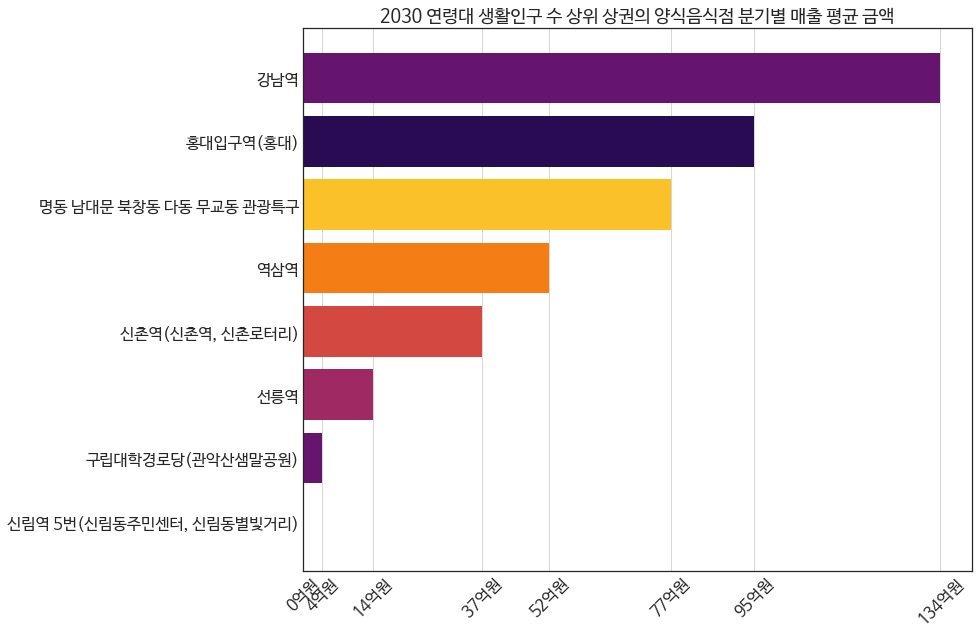

In [65]:
plt.figure(figsize=(12, 10))
plt.barh(best_2030_population_area_mean_sales.index, best_2030_population_area_mean_sales.values, color=sns.color_palette('inferno'))
plt.xticks(best_2030_population_area_mean_sales.values, [f'{int(x/100000000)}억원' for x in best_2030_population_area_mean_sales.values], rotation=45, size=16)
plt.yticks(size=16)
plt.title('2030 연령대 생활인구 수 상위 상권의 양식음식점 분기별 매출 평균 금액', size=18)
plt.grid(axis='x')
plt.show()

> 이처럼 `강남역` 상권이 압도적으로 많은 것을 확인할 수 있습니다.
>
> 하지만, 매출이 많다고 단순히 성공할 가능성이 가장 높은 상권이라고 하기 힘듭니다.
>
> 분석 과정에서 제외했던 `까치산 3번` 상권의 경우 양식음식점이 집계되지 않았으므로 매출액은 0이지만 평균 30대 생활인구 수는 상위 4위에 해당하는 가능성있는 상권이기 때문입니다.
>
> 이 때 중요한 차이점은 `상권 내 동일 업종의 개수` 즉, 경쟁 상대가 얼마나 많은가입니다.
>
> 다음으로는 이에 대해 분석해보고 평균 매출액에서 총 개수를 나눠주어 각 양식음식점의 기대 매출 평균액을 구해보도록 하겠습니다.
>
>> 위와 같은 계산으로 `까치산 3번` 상권은 0/0이므로 그 가능성이 쪽박 아니면 대박이 될 수 있을 것입니다.